### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [103]:
data = pd.read_csv('data/Whickham.txt')

In [104]:
data.sample(10)

,outcome,smoker,age
550,Dead,No,78
481,Alive,No,41
268,Alive,Yes,37
81,Dead,No,79
236,Dead,No,50
482,Alive,No,41
512,Alive,No,30
1275,Alive,Yes,18
667,Alive,No,63
1229,Dead,Yes,55


In [105]:
data['smoker'] = (data['smoker']=="Yes")*1 

In [106]:
X = data[['smoker', 'age']]
y = data['outcome']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

In [108]:
dtree = DecisionTreeClassifier(max_depth = 1).fit(X, y)

In [110]:
p_grid = {'dtree__max_depth': [5, 6, 7, 8, 9],
         'dtree__min_samples_split': [2,3,4],
          'dtree__criterion': ["gini", "entropy"],
          'dtree__min_samples_leaf': [2,3,4]
         }

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

### GridSearchCV

In [111]:
grid_pipe = Pipeline([('dtree', DecisionTreeClassifier())]).fit(X_train,y_train)

In [112]:
%%time
grid = GridSearchCV(grid_pipe, param_grid = p_grid)
grid.fit(X_train, y_train)

CPU times: user 1.79 s, sys: 6.66 ms, total: 1.8 s
Wall time: 1.81 s


GridSearchCV(estimator=Pipeline(steps=[('dtree', DecisionTreeClassifier())]),
             param_grid={'dtree__criterion': ['gini', 'entropy'],
                         'dtree__max_depth': [5, 6, 7, 8, 9],
                         'dtree__min_samples_leaf': [2, 3, 4],
                         'dtree__min_samples_split': [2, 3, 4]})

In [124]:
grid.best_estimator_

Pipeline(steps=[('dtree',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=4))])

In [113]:
grid_df=pd.DataFrame(grid.best_params_, index=[0])
grid_df.columns = grid_df.columns.str.replace("dtree__", "")
grid_df

,criterion,max_depth,min_samples_leaf,min_samples_split
0,gini,5,4,2


In [114]:
dtree_gcv=DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=4, 
                                 min_samples_split=2).fit(X_train,y_train)

best_train_accuracy_gcv = round(dtree_gcv.score(X_train,y_train),4)
best_test_accuracy_gcv = round(dtree_gcv.score(X_test,y_test),4)
print('best_train_accuracy_gcv =>',best_train_accuracy_gcv)
print('best_test_accuracy_gcv  =>',best_test_accuracy_gcv)

best_train_accuracy_gcv => 0.8548
best_test_accuracy_gcv  => 0.8663


### RandomizedSearchCV

In [115]:
%%time
random = RandomizedSearchCV(grid_pipe,p_grid)
random.fit(X_train, y_train)

CPU times: user 206 ms, sys: 2.67 ms, total: 209 ms
Wall time: 208 ms


RandomizedSearchCV(estimator=Pipeline(steps=[('dtree',
                                              DecisionTreeClassifier())]),
                   param_distributions={'dtree__criterion': ['gini', 'entropy'],
                                        'dtree__max_depth': [5, 6, 7, 8, 9],
                                        'dtree__min_samples_leaf': [2, 3, 4],
                                        'dtree__min_samples_split': [2, 3, 4]})

In [125]:
random.best_estimator_

Pipeline(steps=[('dtree',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                                        min_samples_split=3))])

In [116]:
random_df=pd.DataFrame(random.best_params_, index=[0])
random_df.columns = random_df.columns.str.replace("dtree__", "")
random_df

,min_samples_split,min_samples_leaf,max_depth,criterion
0,3,2,5,gini


In [117]:
dtree_random=DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=2, 
                                 min_samples_split=3).fit(X_train,y_train)

best_train_accuracy_random = round(dtree_random.score(X_train,y_train),4)
best_test_accuracy_random = round(dtree_random.score(X_test,y_test),4)
print('best_train_accuracy_random =>',best_train_accuracy_random)
print('best_test_accuracy_random  =>',best_test_accuracy_random)

best_train_accuracy_random => 0.8558
best_test_accuracy_random  => 0.8693


### HalvingGridSearchCV

In [118]:
%%time
n_samples = len(X_train)
halving = HalvingGridSearchCV(grid_pipe, p_grid, resource='n_samples', min_resources=n_samples, factor=2)
halving.fit(X_train, y_train)

CPU times: user 2.66 s, sys: 8.73 ms, total: 2.67 s
Wall time: 2.68 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('dtree',
                                               DecisionTreeClassifier())]),
                    factor=2, min_resources=985,
                    param_grid={'dtree__criterion': ['gini', 'entropy'],
                                'dtree__max_depth': [5, 6, 7, 8, 9],
                                'dtree__min_samples_leaf': [2, 3, 4],
                                'dtree__min_samples_split': [2, 3, 4]})

In [126]:
halving.best_estimator_

Pipeline(steps=[('dtree',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=4))])

In [119]:
halving_df=pd.DataFrame(halving.best_params_, index=[0])
halving_df.columns = halving_df.columns.str.replace("dtree__", "")
halving_df

,criterion,max_depth,min_samples_leaf,min_samples_split
0,gini,5,4,2


In [120]:
dtree_halving=DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=4, 
                                 min_samples_split=2).fit(X_train,y_train)

best_train_accuracy_halving = round(dtree_halving.score(X_train,y_train),4)
best_test_accuracy_halving = round(dtree_halving.score(X_test,y_test),4)
print('best_train_accuracy_halving =>',best_train_accuracy_halving)
print('best_test_accuracy_halving  =>',best_test_accuracy_halving)

best_train_accuracy_halving => 0.8548
best_test_accuracy_halving  => 0.8663


### HalvingRandomSearchCV

In [121]:
%%time
halving_random = HalvingRandomSearchCV(grid_pipe, p_grid)
halving_random.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 6.7 ms, total: 1.54 s
Wall time: 1.54 s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('dtree',
                                                 DecisionTreeClassifier())]),
                      param_distributions={'dtree__criterion': ['gini',
                                                                'entropy'],
                                           'dtree__max_depth': [5, 6, 7, 8, 9],
                                           'dtree__min_samples_leaf': [2, 3, 4],
                                           'dtree__min_samples_split': [2, 3,
                                                                        4]})

In [127]:
halving_random.best_estimator_

Pipeline(steps=[('dtree',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=4))])

In [122]:
halving_random_df=pd.DataFrame(halving_random.best_params_, index=[0])
halving_random_df.columns = halving_random_df.columns.str.replace("dtree__", "")
halving_random_df

,min_samples_split,min_samples_leaf,max_depth,criterion
0,2,4,8,gini


In [123]:
dtree_halving_random=DecisionTreeClassifier(max_depth=8, criterion='gini', min_samples_leaf=4, 
                                 min_samples_split=2).fit(X_train,y_train)

best_train_accuracy_halving_random = round(dtree_halving_random.score(X_train,y_train),4)
best_test_accuracy_halving_random = round(dtree_halving_random.score(X_test,y_test),4)
print('best_train_accuracy_halving_random =>',best_train_accuracy_halving_random)
print('best_test_accuracy_halving_random  =>',best_test_accuracy_halving_random)

best_train_accuracy_halving_random => 0.8569
best_test_accuracy_halving_random  => 0.8632


### Plot-1 Search Type vs Time

In [153]:
data = {'Grid Search': ['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV'], 
        'Total Time': [1.8, 0.21, 2.67, 1.54]}

df = pd.DataFrame(data)
df.index = df['Grid Search']
df.drop(['Grid Search'], axis=1)

,Total Time
Grid Search,
GridSearchCV,1.80
RandomizedSearchCV,0.21
HalvingGridSearchCV,2.67
HalvingRandomSearchCV,1.54


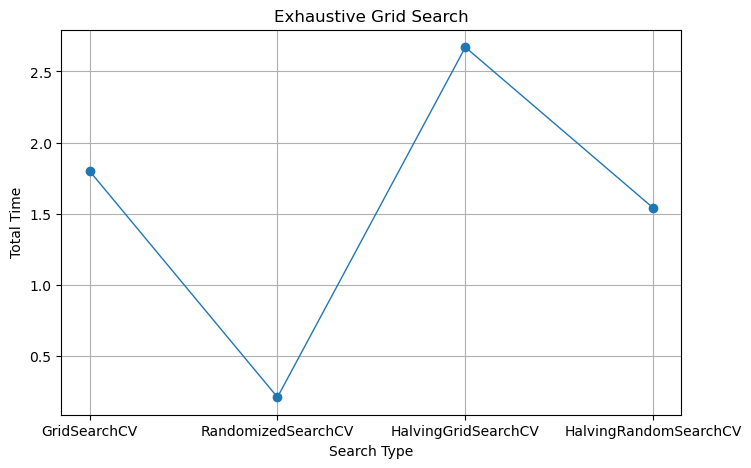

In [165]:
plt.figure(figsize=(8,5))
plt.plot(df['Total Time'], 'o-',label='Total Time for Searches', linewidth=1)
plt.xlabel('Search Type')
plt.ylabel('Total Time')
plt.grid()
plt.title('Exhaustive Grid Search')
plt.show()

### Plot-2 Accuracy Scores

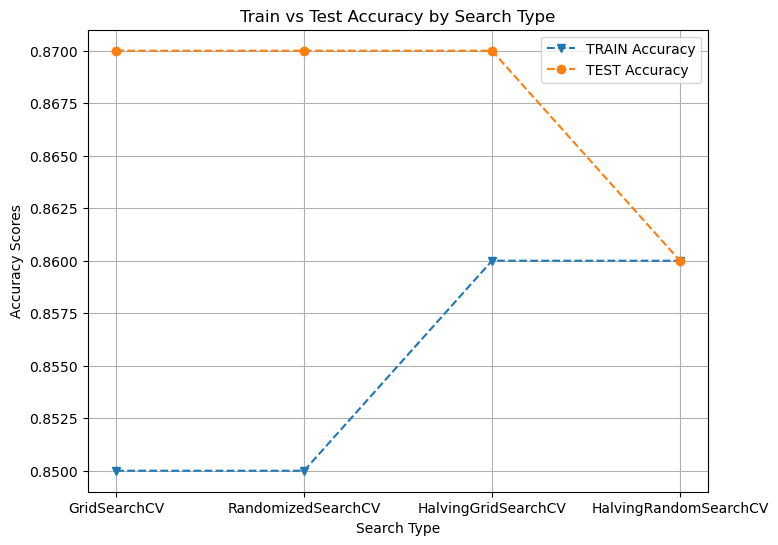

In [173]:
data_1 = {'Grid Search': ['GridSearchCV', 'RandomizedSearchCV', 'HalvingGridSearchCV', 'HalvingRandomSearchCV'], 
        'Train Accuracy': [0.85, 0.85, 0.86, 0.86],
        'Test Accuracy' : [0.87, 0.87, 0.87, 0.86]
       }

df_1 = pd.DataFrame(data_1)
df_1.index = df_1['Grid Search']
df_1.drop(['Grid Search'], axis=1)

plt.figure(figsize=(8,6))
plt.plot(df_1['Grid Search'], df_1['Train Accuracy'], '--v', label = 'TRAIN Accuracy')
plt.plot(df_1['Grid Search'], df_1['Test Accuracy'], '--o', label = 'TEST Accuracy')
plt.xticks(df_1['Grid Search'])
plt.legend()
plt.title('Train vs Test Accuracy by Search Type')
plt.xlabel('Search Type')
plt.ylabel('Accuracy Scores')
plt.grid();